From: https://salzis.wordpress.com/2014/06/10/robust-linear-model-estimation-using-ransac-python-implementation/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
import pandas as pd
import os
from importing import load_nyu_images
from tqdm import tqdm_notebook as tqdm
from pyntcloud import PyntCloud as pc

from Planes import find_plane, distance_from_plane

/home/clh/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
path = r'/home/clh/datasets/NYU Depth Dataset V2'
file = r'nyu_depth_v2_labeled.mat'
file_path = os.path.join(path, file)

Max depth: 1.0
Min depth: 0.0


Text(0.5,1,'1 channel raw depth')

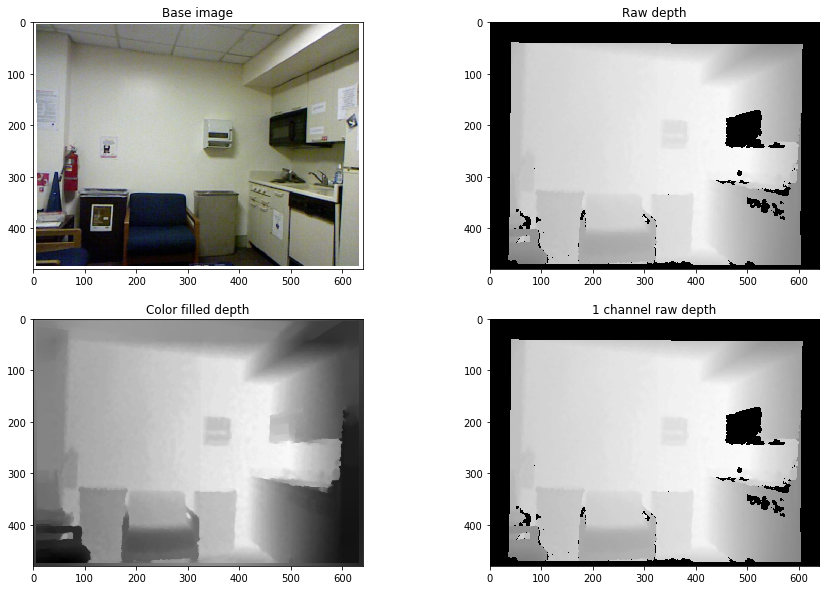

In [3]:
f, subs = plt.subplots(2, 2, figsize=(15, 10))
im, raw_depth, depth = load_nyu_images(file_path, 0, norm_depth=True)
print("Max depth: {}".format(np.max(raw_depth)))
print("Min depth: {}".format(np.min(raw_depth)))
raw_depth_1_channel = (raw_depth[:,:,0] + raw_depth[:,:,1] + raw_depth[:,:,2]) / 3.0
rd1c_df = pd.DataFrame(raw_depth_1_channel)
#print(rd1c_df.describe())
subs[0][0].imshow(im)
subs[0][0].set_title("Base image")
subs[0][1].imshow(raw_depth)
subs[0][1].set_title("Raw depth")
subs[1][0].imshow(depth)
subs[1][0].set_title("Color filled depth")
subs[1][1].imshow(raw_depth_1_channel, cmap='gray')
subs[1][1].set_title("1 channel raw depth")

- pick 3 random points
- find model for points
- Find distance of (other) points to plane
    - Count inliers
- If model is better (mode inliers), save it

In [4]:
def get_inliers(p1, p2, p3, points, limit):
    p_a, p_b, p_c, p_d = find_plane(p1, p2, p3)
    
    #dists = np.zeros(depth.shape)

    #for x in range(depth.shape[0]):
    #    for y in range(depth.shape[1]):
    #        p = np.array([x, y, depth[x, y]])
    #        dists[x, y] = distance_from_plane(p, p_a, p_b, p_c, p_d)
    
    dists = distance_from_plane(points, p_a, p_b, p_c, p_d)
    #inliers = points[dists<limit]
    inliers = dists[dists<limit]
    
    res = {"Plane": [p_a, p_b, p_c, p_d],
           "num_inliers": inliers.shape[0],
           "inliers": inliers,
           "dists": dists}
    
    return res

In [5]:
def get_rand_point(depth):
    xs = range(depth.shape[0])
    ys = range(depth.shape[1])
    
    rand_xs = np.random.choice(xs, 3)
    rand_ys = np.random.choice(ys, 3)
    d = depth[rand_xs[0], rand_ys[0]]
    
    while d == 0.0:
        rand_xs = np.random.choice(xs, 3)
        rand_ys = np.random.choice(ys, 3)
        d = depth[rand_xs[0], rand_ys[0]]
        
    return np.array([rand_xs[0], rand_ys[0], d])

In [6]:
def do_ransac(depth, iterations, limit=0.001):
    best_fit = None
    
    ps = np.zeros((depth.shape[0], depth.shape[1], 3))
    
    #print(depth)
    counter = 0
    for x in range(depth.shape[0]):
        for y in range(depth.shape[1]):
            #ps[counter] = np.array([x, y, depth[x, y]])
            ps[x, y] = np.array([x, y, depth[x, y]])
            counter += 1
    
    for ite in tqdm(range(iterations)):
        
        #p1 = np.array([rand_xs[0], rand_ys[0], depth[rand_xs[0], rand_ys[0]]])
        #p2 = np.array([rand_xs[1], rand_ys[1], depth[rand_xs[1], rand_ys[1]]])
        #p3 = np.array([rand_xs[2], rand_ys[2], depth[rand_xs[2], rand_ys[2]]])
        p1 = get_rand_point(depth)
        p2 = get_rand_point(depth)
        p3 = get_rand_point(depth)
    
        fit = get_inliers(p1, p2, p3, ps, limit)
        
        if best_fit is None:
            best_fit = fit
        else:
            if fit["num_inliers"] > best_fit["num_inliers"]:
                best_fit = fit
        
    return best_fit

In [7]:
xs = range(raw_depth_1_channel.shape[0])
ys = range(raw_depth_1_channel.shape[1])
rand_xs = np.random.choice(xs, 3)
rand_ys = np.random.choice(ys, 3)

p1 = np.array([rand_xs[0], rand_ys[0], raw_depth_1_channel[rand_xs[0], rand_ys[0]]])
p2 = np.array([rand_xs[1], rand_ys[1], raw_depth_1_channel[rand_xs[1], rand_ys[1]]])
p3 = np.array([rand_xs[2], rand_ys[2], raw_depth_1_channel[rand_xs[2], rand_ys[2]]])

print(p1)
print(p2)
print(p3)

p_a, p_b, p_c, p_d = find_plane(p1, p2, p3)

d = distance_from_plane((p1, p2, p3), p_a, p_b, p_c, p_d)
d

[445.         520.           0.66304334]
[373.         145.           0.77510041]
[474. 142.   0.]


array([0., 0., 0.])

In [8]:
#r = get_inliers(p1, p2, p3, raw_depth_1_channel)

In [9]:
num_points = raw_depth_1_channel.shape[0]*raw_depth_1_channel.shape[1]
print("Number of points: {}".format(num_points))

Number of points: 307200


In [10]:
lim = 0.02
ran = do_ransac(raw_depth_1_channel, 300, lim)
0
cond = np.less(ran["dists"], lim)
ran["inliers"].shape

(106021,)

In [11]:
point_cloud = np.zeros((num_points, 6))

counter = 0
plane_points = 0
for x in range(raw_depth_1_channel.shape[0]):
    for y in range(raw_depth_1_channel.shape[1]):
        # Skip invalid points
        if raw_depth_1_channel[x, y] != 0.0:
            point_cloud[counter, 0] = x
            point_cloud[counter, 1] = y
            point_cloud[counter, 2] = -raw_depth_1_channel[x, y] * 255.0 * 1
            #point_cloud[counter, 2] = -np.log(raw_depth_1_channel[x, y]) * 255.0
            #point_cloud[counter, 2] = np.tan(raw_depth_1_channel[x, y]+0.5)
            if raw_depth_1_channel[x, y] != 0:

                point_cloud[counter, 3] = im[x, y, 0] * 255.0
                point_cloud[counter, 4] = im[x, y, 1] * 255.0
                if cond[x, y]:
                    point_cloud[counter, 5] = 255.0
                    plane_points += 1
                else:
                    point_cloud[counter, 5] = im[x, y, 2] * 255.0
            else:
                point_cloud[counter, 3] = 0
                point_cloud[counter, 4] = 0
                point_cloud[counter, 5] = 0
            counter += 1
print("Plane points: {}".format(plane_points))

Plane points: 106021


In [12]:
"""
counter = 0
for p in tqdm(point_cloud[:,0:3]):
    if p in ran["inliers"]:
        print(p)
        print(ran["inliers"][ran["inliers"]==p])
        break
        counter += 1
counter
"""

'\ncounter = 0\nfor p in tqdm(point_cloud[:,0:3]):\n    if p in ran["inliers"]:\n        print(p)\n        print(ran["inliers"][ran["inliers"]==p])\n        break\n        counter += 1\ncounter\n'

In [13]:
points = pd.DataFrame(point_cloud, columns=['x', 'y', 'z', 'red', 'green', 'blue'])
points.describe()

,x,y,z,red,green,blue
count,307200.000000,307200.000000,307200.000000,307200.000000,307200.000000,307200.000000
mean,194.747256,240.401188,-159.080954,96.056246,96.584042,123.015476
std,154.014762,195.358080,92.170154,75.318259,76.517453,107.356486
min,0.000000,0.000000,-255.000000,0.000000,0.000000,0.000000
25%,49.000000,46.000000,-222.692317,4.000000,3.000000,3.000000
50%,185.000000,227.000000,-204.211612,115.000001,113.000001,106.000001
75%,330.000000,408.000000,-140.032315,165.000005,167.000005,255.000000
max,471.000000,606.000000,0.000000,249.000000,245.000001,255.000000


In [14]:
cloud = pc(points)
cloud.plot(IFrame_shape=(1200, 700))